# Northwestern County Housing Renovation Analysis

Author: Armun Shakeri

# Overview

This project analyzes housing renovations and how renovations might increase the value of a property owners home. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to sell their homes, home renovations might be a way homeowners can increase their property value. This project analyzes these renovations and explores if they do have a positive increase on the house's value. 

# Data Understanding

The following data is imported from KC house data and shows different data about homes such as the date a home was sold, price, bedrooms...etc. For this project we will not need to use some of these columns, they will be removed. 

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [ ]:
# this shows information regarding variables in kc dataframe 
kc.info()

In [3]:
# Below we drop values that are irrelevant towards first time hombe buyer analysis 
kc = kc.drop(['date', 'view', 'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15', 
        'sqft_lot15', 'waterfront'], axis=1)
kc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,yr_renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,7 Average,1955,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,7 Average,1951,1991.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,Average,6 Low Average,1933,NaN
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,7 Average,1965,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,8 Good,1987,0.0


In [6]:
# Here we drop all Na values. 
kc=kc.dropna()

In [15]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4 will also be removed. 
kc = kc[kc.price<1000000][kc.bedrooms<=4]
kc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,yr_renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,7 Average,1955,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,7 Average,1951,1991.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,7 Average,1965,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,8 Good,1987,0.0
6,1321400060,257500.0,3,2.25,1715,6819,2.0,Average,7 Average,1995,0.0


In [9]:
kc.sort_values('bedrooms', ascending=False).head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,yr_renovated
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,Very Good,7 Average,1947,0.0
8748,1773100755,520000.0,11,3.00,3000,4960,2.0,Average,7 Average,1918,1999.0
15147,5566100170,650000.0,10,2.00,3610,11914,2.0,Good,7 Average,1958,0.0
19239,8812401450,660000.0,10,3.00,2920,3745,2.0,Good,7 Average,1913,0.0
8537,424049043,450000.0,9,7.50,4050,6504,2.0,Average,7 Average,1996,0.0


# Data Modeling

In [17]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
count,1.525500e+04,15255.000000,15255.000000,15255.000000,15255.000000,1.525500e+04,15255.000000,15255.000000,15255.000000
mean,4.617411e+09,459188.830351,3.166765,1.991462,1888.533596,1.462070e+04,1.468535,1970.845952,70.890003
std,2.880827e+09,192289.751335,0.702304,0.668570,710.859540,4.076196e+04,0.538926,29.074381,369.373112
min,1.200019e+06,80000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000,0.000000
25%,2.167650e+09,308000.000000,3.000000,1.500000,1360.000000,5.000000e+03,1.000000,1951.000000,0.000000
50%,3.905081e+09,425000.000000,3.000000,2.000000,1790.000000,7.421000e+03,1.000000,1975.000000,0.000000
75%,7.349650e+09,580000.000000,4.000000,2.500000,2320.000000,1.014150e+04,2.000000,1996.000000,0.000000
max,9.895000e+09,999999.000000,4.000000,5.000000,6050.000000,1.651359e+06,3.500000,2015.000000,2015.000000


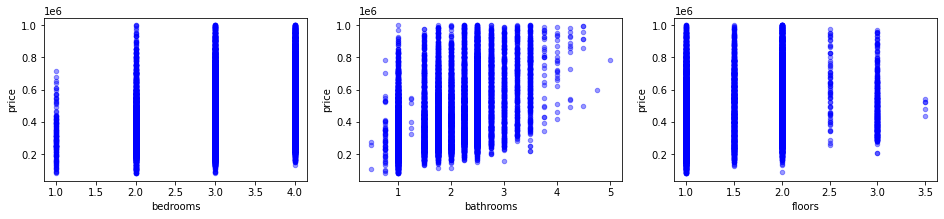

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'yr_built'], axes):
    kc.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')